# Chapter 2. Text Classification

## Setup

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    accuracy_score,
    f1_score,
)

# PyTorch
import torch
from torch.nn import functional as F
from torch.nn.functional import cross_entropy

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras import metrics, optimizers, losses

# Hugging Face
from datasets import list_datasets, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    TFAutoModelForSequenceClassification,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)

## The Dataset

In [3]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are:{all_datasets[:10]}")

/var/folders/l8/6g7jw01d22z1cl19whfqrxhw0000gn/T/ipykernel_81652/659847701.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 50917 datasets currently available on the Hub
The first 10 are:['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

### From Datasets to DataFrames

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


In [11]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

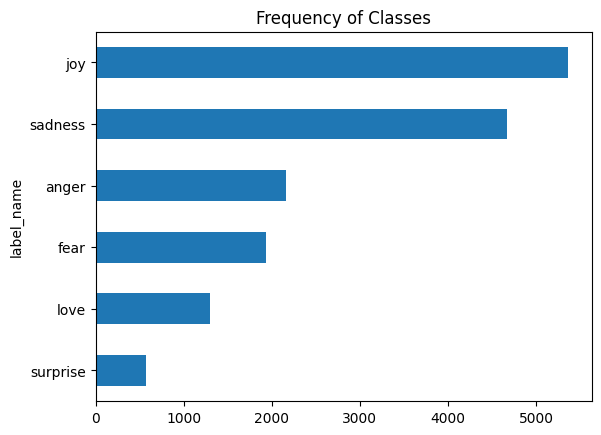

In [12]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### How Long Are Our Tweets?

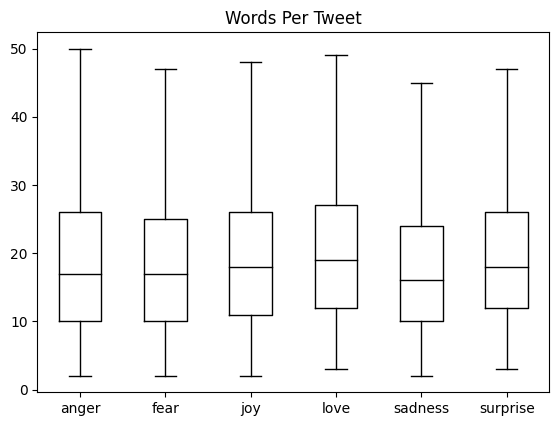

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions.reset_format()

## From Text to Tokens

### Character Tokenization

In [15]:
text = "Tokenizing text is a core task for NLP"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'f', 'o', 'r', ' ', 'N', 'L', 'P']


In [16]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


In [17]:
inputs_ids = [token2idx[token] for token in tokenized_text]
print(inputs_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 8, 13, 14, 0, 2, 1, 3]


In [18]:
input_ids = torch.tensor(inputs_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 19])

In [19]:
print(f"token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

token: T
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization

In [20]:
tokenized_test = text.split()
print(tokenized_test)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'for', 'NLP']


### Subword Tokenization

In [21]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 2005, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [23]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'for', 'nl', '##p', '[SEP]']


In [24]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task for nlp [SEP]


In [25]:
tokenizer.vocab_size

30522

In [26]:
tokenizer.model_max_length

512

In [27]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the Whole Dataset

In [28]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [30]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [31]:
emotions_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

## Training a Text Classifier

### Transformers as Feature Extractors

In [32]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("mps" if torch.has_mps else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [33]:
text = "This is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [34]:
inputs = {k:v.to(device) for k, v in inputs.items()}


In [35]:
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='mps:0'), hidden_states=None, attentions=None)


In [36]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [37]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [38]:
def extract_hidden_states(batch):
    # Move input vector to the GPU
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return only for the CLS token at the beginning
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [39]:
# Change the format of the dataset to Torch
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Extract hidden states
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [40]:
x_train = np.array(emotions_hidden["train"]["hidden_state"])
x_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

### Visualizing the training set

In [41]:
# Scale the features 
x_scaled = MinMaxScaler().fit_transform(x_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(x_scaled)
# Create a DAtaFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["x", "y"])
df_emb["label"] = y_train
df_emb.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,x,y,label
0,4.454646,6.070521,0
1,-3.059013,5.180450,0
2,5.279346,2.479157,3
3,-2.348542,3.241681,2
4,-3.264323,3.100603,3


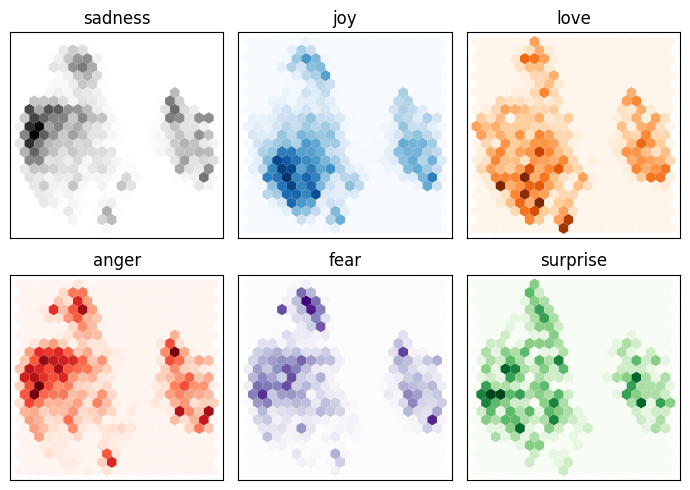

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(
        df_emb_sub["x"], 
        df_emb_sub["y"],
        cmap=cmap,
        gridsize=20,
        linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Train a simple classifier

In [43]:
# We inrease 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.6335

In [44]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

In [45]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

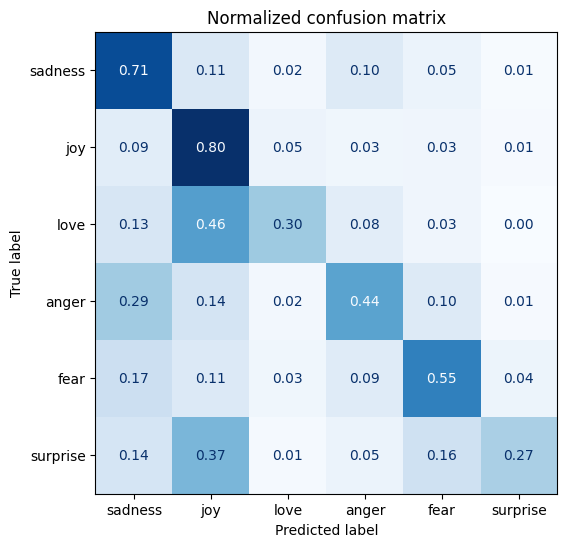

In [46]:
y_preds = lr_clf.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

### Loading a Pretrained Model

In [47]:
num_labels = 6
model = (
    AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device)
)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ab12ef4f-d9a1-4cbc-a592-030aa1145955)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the performance metrics

In [48]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1":f1}

### Training the model

In [49]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/mmenendezg/.cache/huggingface/token
Login successful


In [50]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
model_path = os.path.join("../models/", model_name)
training_args = TrainingArguments(
    output_dir=model_path,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

In [51]:
# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

# train the model
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/mmenendezg/Developer/Books/nlp-transformers/notebooks/../models/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/mmenendezg/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.7973, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3062579333782196, 'eval_accuracy': 0.915, 'eval_f1': 0.9147164633870425, 'eval_runtime': 5.4944, 'eval_samples_per_second': 364.008, 'eval_steps_per_second': 5.824, 'epoch': 1.0}
{'loss': 0.2408, 'learning_rate': 0.0, 'epoch': 2.0}
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Di

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.20469467341899872, 'eval_accuracy': 0.9295, 'eval_f1': 0.9291434862021454, 'eval_runtime': 5.1159, 'eval_samples_per_second': 390.937, 'eval_steps_per_second': 6.255, 'epoch': 2.0}
{'train_runtime': 353.0632, 'train_samples_per_second': 90.635, 'train_steps_per_second': 1.416, 'train_loss': 0.5190691452026367, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5190691452026367, metrics={'train_runtime': 353.0632, 'train_samples_per_second': 90.635, 'train_steps_per_second': 1.416, 'train_loss': 0.5190691452026367, 'epoch': 2.0})

In [52]:
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [53]:
preds_output.metrics

{'test_loss': 0.20469467341899872,
 'test_accuracy': 0.9295,
 'test_f1': 0.9291434862021454,
 'test_runtime': 5.0167,
 'test_samples_per_second': 398.667,
 'test_steps_per_second': 6.379}

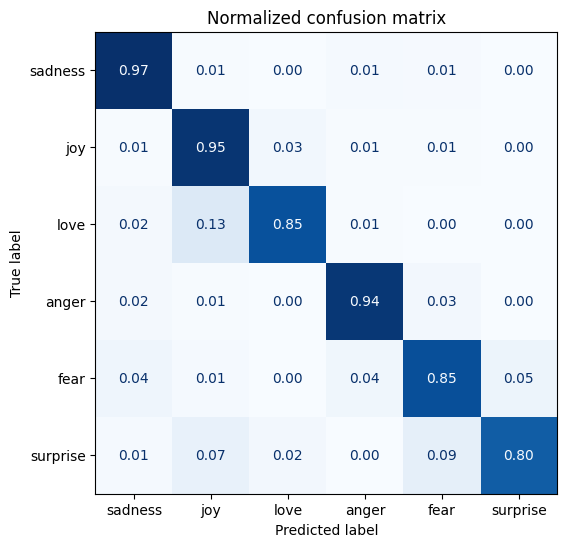

In [54]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning with Keras

In [55]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 16099e6b-6c1a-4e17-9dfc-299709f2b91b)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json


In [56]:
# List of columns for the dataset
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"],
    shuffle=True,
    batch_size=batch_size
)

tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"],
    shuffle=False,
    batch_size=batch_size
)

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [57]:
tf_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics.SparseCategoricalAccuracy(),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5)
)


In [58]:
tf_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=2
)

Epoch 1/2
250/250 [==============================] - 200s 773ms/step - loss: 0.5154 - sparse_categorical_accuracy: 0.8185 - val_loss: 0.1660 - val_sparse_categorical_accuracy: 0.9310
Epoch 2/2
250/250 [==============================] - 191s 763ms/step - loss: 0.1144 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.1558 - val_sparse_categorical_accuracy: 0.9355


### Error Analysis

In [59]:
def forward_pass_with_label(batch):
    # Place all inputs in the same device of the model
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [60]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [61]:
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [62]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [63]:
# Predictions with the highest loss 
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.565771
1963,i called myself pro life and voted for perry w...,joy,sadness,5.446492
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.426248
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.259390
882,i feel badly about reneging on my commitment t...,love,sadness,5.031295
1509,i guess this is a memoir so it feels like that...,joy,fear,4.881896
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.817453
1111,im lazy my characters fall into categories of ...,joy,fear,4.758934
1840,id let you kill it now but as a matter of fact...,joy,fear,4.265648
1683,i had applied for a job and they had assured m...,anger,joy,4.125869


In [64]:
# Predictions with the lowest loss
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.016259
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.016410
1310,i feel like an ungrateful asshole,sadness,sadness,0.016469
267,i feel like im alone in missing him and becaus...,sadness,sadness,0.016620
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.016662
392,i remember feeling disheartened one day when w...,sadness,sadness,0.016670
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.016707
571,i realize that i sound a little overdramatic w...,sadness,sadness,0.016735
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.016886
783,i feel like i deserve to be broke with how fri...,sadness,sadness,0.016904


### Saving and Sharing the Model

In [65]:
trainer.push_to_hub(commit_message="Model successfully trained!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file runs/Aug07_20-45-17_Marlons-MacBook-Pro.local/events.out.tfevents.1691462720.Marlons-MacBook-Pro.l…

To https://huggingface.co/mmenendezg/distilbert-base-uncased-finetuned-emotion
   1c802f3..b2d718d  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/mmenendezg/distilbert-base-uncased-finetuned-emotion
   b2d718d..d8535a6  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/mmenendezg/distilbert-base-uncased-finetuned-emotion/commit/b2d718d0899bbe74b5df2f7d39433ba875984e72'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


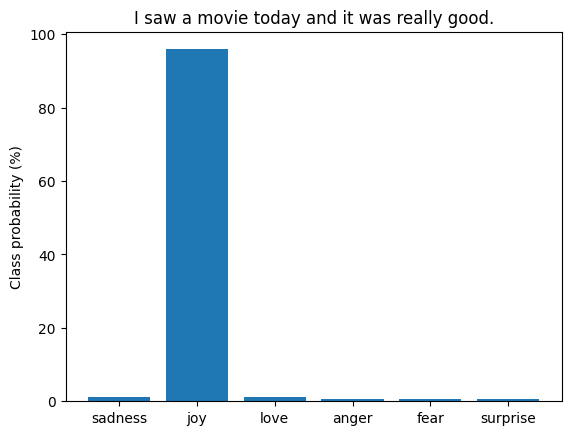

In [66]:
# Pull the model we just save
custom_model_id = "mmenendezg/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=custom_model_id)

# Make predictions using the model
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

# Plot the predictions
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f"{custom_tweet}")
plt.ylabel("Class probability (%)")
plt.show()